---
title: "Supervised Learning"
format:
    html:
        embed-resources: true
        code-fold: false
---

In [ ]:
#| echo: false
#| warning: false

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
#| echo: false
#| warning: false

# Set pandas options to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Breast (BRCA) Cancer Survival Time (days) Prediction Using Supervised Learning Models

## Data Preprocessing

We had preserved multiple rows from the same patient to track treatments recevied during exploratory data analysis.

In [ ]:
#| echo: false
#| warning: false
#| tbl-cap: "First two rows of the eda BRCA clinical dataset"

# Load the data

brca_df = pd.read_csv('data/processed-data/brca/brca-clinical-processed.tsv', sep='\t')
brca_df.head(2)

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.primary_site,cases.submitter_id,demographic.age_is_obfuscated,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_stage,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.diagnosis_is_primary_disease,diagnoses.laterality,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.sites_of_involvement,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior
0,tcga-brca,001cef41-ff86-4d3f-a140-a647ac4b10a1,ductal and lobular neoplasms,diagnosis,breast,tcga-e2-a1iu,False,NaN,not hispanic or latino,female,white,tcga-e2-a1iu_demographic,alive,60.0,m0,n0 (mol+),stage ia,t1c,primary,0,337.0,True,right,surgical resection,8500/3,"infiltrating duct carcinoma, nos",False,False,"breast, nos","breast, right upper outer",tcga-e2-a1iu_diagnosis,False,"breast, nos",tcga-e2-a1iu_treatment2,False,"radiation therapy, nos",337.0,malignant
1,tcga-brca,001cef41-ff86-4d3f-a140-a647ac4b10a1,ductal and lobular neoplasms,diagnosis,breast,tcga-e2-a1iu,False,NaN,not hispanic or latino,female,white,tcga-e2-a1iu_demographic,alive,60.0,m0,n0 (mol+),stage ia,t1c,primary,0,337.0,True,right,surgical resection,8500/3,"infiltrating duct carcinoma, nos",False,False,"breast, nos","breast, right upper outer",tcga-e2-a1iu_diagnosis,False,"breast, nos",tcga-e2-a1iu_treatment,True,hormone therapy,337.0,malignant


However, for supervised learning, this could lead to data leakage during model training and evaluation. To mitigate this, we implemented a preprocessing step to retain only one record per patient. We selected the most recent record for each patient who received treatment, and created a column `treatment.count` to captuure the effect of multiple treatments a patient received.

In [ ]:
#| echo: false
#| warning: false

# Remove duplicate cases.submitter_id columns by first grouping by the column, taking a count of each group as treatments.count, then preserving row with treatments.treatment_or_therapy = true else preserve the first row in each group

# Add a count column for each group of cases.submitter_id
brca_df['treatments.count'] = brca_df.groupby('cases.submitter_id')['cases.submitter_id'].transform('count')

# Create a custom sorting key to prioritize rows with treatments.treatment_or_therapy = True
def create_sort_key(df):
    """Create a sort key that prioritizes treatment_or_therapy = True, then original index"""
    # Convert to string
    treatment_col = df['treatments.treatment_or_therapy'].astype(str).str.lower()
    
    # Create priority: True gets 0 (highest priority), others get 1
    priority = (treatment_col != 'true').astype(int)
    
    return priority

# Sort by cases.submitter_id and then by custom priority
brca_df['sort_priority'] = create_sort_key(brca_df)
brca_df_sorted = brca_df.sort_values(['cases.submitter_id', 'sort_priority'])

# Keep the first row for each cases.submitter_id
brca_df_deduplicated = brca_df_sorted.drop_duplicates(subset=['cases.submitter_id'], keep='first')

# Remove the temporary sorting column
brca_df_deduplicated = brca_df_deduplicated.drop('sort_priority', axis=1)

print(f"\nAfter deduplication:")
print(f"Deduplicated dataset shape: {brca_df_deduplicated.shape}")
print(f"Unique cases.submitter_id: {brca_df_deduplicated['cases.submitter_id'].nunique()}")
print(f"Rows removed: {brca_df.shape[0] - brca_df_deduplicated.shape[0]}")

# Show treatment distribution in deduplicated data
print(f"\nTreatment distribution in deduplicated data:")
print(brca_df_deduplicated['treatments.treatment_or_therapy'].value_counts(dropna=False))

# Update the main dataframe
brca_df = brca_df_deduplicated.copy()
print(f"\nFinal BRCA dataset shape: {brca_df.shape}")


After deduplication:
Deduplicated dataset shape: (1081, 39)
Unique cases.submitter_id: 1081
Rows removed: 3815

Treatment distribution in deduplicated data:
treatments.treatment_or_therapy
True     1076
False       5
Name: count, dtype: int64

Final BRCA dataset shape: (1081, 39)


In [ ]:
#| echo: false
#| warning: false

# Save the cleaned dataset
brca_df.to_csv('data/processed-data/brca/brca-clinical-ml.tsv', sep='\t', index=False)

Our next step involved feature selection to enhance model performance and interpretability. We focused on removing non-informative features that exhibited low variance across the dataset. Features with little to no variability do not contribute meaningful information for predicting survival time and can introduce noise into the model.

**Remove Non-informative Features**: Exclude features with low variance e.g., behavior of the tumor is malignant for all samples. Dropped features:

   - `project_id`: represents the project and is constant for all samples.
   - `case_id`: unique identifier for each case, not useful for prediction.
   - `submitter_id`: unique identifier for each submitter, not useful for prediction.
   - `primary_site`: all samples are from the breast, so this feature has no variance.
   - `index_date`: date of indexing, not relevant for prediction.
   - `age_is_obfuscated`: flag indicating if age is obfuscated, not useful for prediction.
   - `days_to_death`: not applicable for all samples, leading to missing values.
   - `ethnicity`: heavy imbalance to not hispanic or latino (over 80% of samples), leading to low variance. Race might capture the variance better.
   - `gender`: all samples are female, so this feature has no variance
   - `classification_of_tumor`: all samples are primary, so this feature has no variance.
   - `days_to_diagnosis`: 0 for all samples, so this feature has no variance.
   - `days_to _last_follow_up`: not applicable for all samples, leading to missing values.
   - `vital_status`: does not make sense to predict survival time based on whether the patient is alive or dead at last follow-up.
   - `laterality`: research indicates no significant difference in breast cancer outcomes based on laterality. Dataset does not show imbalance in laterality distribution.
   - `diagnoses.prior_treatment`: heavy imbalance to false (97% of samples), leading to low variance. Assuming number of treatments is more informative.
   - `site_of_resection_or_biopsy`: all samples are from the breast, so this feature has no variance. Specific location within the breast (sites_of_involvement) may provide more detailed information.
   - `synchronous_malignancy`: heavy imbalance to false (> 97%), so this feature has no variance.
   - `treatments.submitter_id`: unique identifier for each submitter, not useful for prediction.
   - `treatments_or_therapy`: Heavy imbalance to true as most patients receive treatment, so this feature has low variance. Specific treatment types may provide more information.
   - `diagnoses.diagnosis_is_primary_disease`: all samples are primary, so this feature has no variance.
   - `diagnoses.method_of_diagnosis`: Not informative to how long a patient survives. The primary diagnosis might be more relevant.


In [ ]:
#| echo: false
#| warning: false

# Remove non-informative columns above
non_informative_cols = [
    'project.project_id',              
    'cases.case_id',                   
    'cases.submitter_id',              
    'cases.primary_site',              
    'cases.index_date',                
    'demographic.age_is_obfuscated',   
    'demographic.days_to_death',       
    'demographic.gender',              
    'demographic.submitter_id',        
    'diagnoses.classification_of_tumor', 
    'diagnoses.days_to_diagnosis',     
    'diagnoses.days_to_last_follow_up', 
    'diagnoses.laterality',
    'demographic.vital_status',            
    'diagnoses.prior_treatment',       
    'diagnoses.site_of_resection_or_biopsy', 
    'diagnoses.synchronous_malignancy', 
    'diagnoses.submitter_id',          
    'treatments.submitter_id',         
    'treatments.treatment_or_therapy', 
    'diagnoses.behavior',
    'demographic.ethnicity',
    'diagnoses.diagnosis_is_primary_disease',
    'diagnoses.method_of_diagnosis',
    'diagnoses.tissue_or_organ_of_origin'            
]

# Drop the non-informative columns
brca_df_clean = brca_df.drop(columns=non_informative_cols)

print(f"Original dataset shape: {brca_df.shape}")
print(f"Cleaned dataset shape: {brca_df_clean.shape}")
print(f"Columns removed: {brca_df.shape[1] - brca_df_clean.shape[1]}")

# Update the main dataframe
brca_df = brca_df_clean.copy()

Original dataset shape: (1081, 39)
Cleaned dataset shape: (1081, 14)
Columns removed: 25


Lastly, we prepared the data for modeling by applying appropriate transformations to different types of variables:

1. **Normalization**: Numerical columns `age_at_diagnosis` and `treatments.count` normalized using Min-Max scaling.
2. **Boolean Variables**: Converted boolean variables to integers (0 and 1) for model compatibility, vital status to 1 for alive
3. **Ordinal Categorical Variables**: Used Ordinal Encoding for features with an inherent order (e.g., `tumor_stage`).
4.  **Encoding Categorical Variables**: Categorical variables were be encoded using One-Hot Encoding to convert them into a format suitable for machine learning algorithms.

In [ ]:
#| echo: false
#| warning: false

# Min - Max scale diagnoses.age_at_diagnosis
scaler = MinMaxScaler()
brca_df['diagnoses.age_at_diagnosis'] = scaler.fit_transform(brca_df[['diagnoses.age_at_diagnosis']])
brca_df['treatments.count'] = scaler.fit_transform(brca_df[['treatments.count']])

In [ ]:
#| echo: false
#| warning: false

# Change the following 'diagnoses.prior_malignancy' to integers (0 and 1) 
brca_df['diagnoses.prior_malignancy'] = brca_df['diagnoses.prior_malignancy'].map({True: 1, False: 0})

AJCC Cancer Staging Has a Natural Order

Stage I → Stage II → Stage III → Stage IV
Earlier = less severe → later = more severe.

Within each major stage, letters (A, B, C) represent increasing severity, e.g.:

I < IA < IB < II < IIA < IIB < III < IIIA < IIIB < IIIC < IV

In [ ]:
#| echo: false
#| warning: false

# Map AJCC pathologic stages to ordinal values
stage_map = {
    'stage i': 1.0,
    'stage ia': 1.1,
    'stage ib': 1.2,
    'stage ii': 2.0,
    'stage iia': 2.1,
    'stage iib': 2.2,
    'stage iii': 3.0,
    'stage iiia': 3.1,
    'stage iiib': 3.2,
    'stage iiic': 3.3,
    'stage iv': 4.0,
    'stage x': -1
}

brca_df['ajcc_stage_ordinal'] = brca_df['diagnoses.ajcc_pathologic_stage'].map(stage_map)

*T = primary tumor size AND local extent of invasion*

In [ ]:
#| echo: false
#| warning: false

# Similar mapping for patholigic_t
t_stage_map = {
    't1': 1.0,
    't1a': 1.1,
    't1b': 1.2,
    't1c': 1.3,
    't2': 2.0,
    't2a': 2.1,
    't2b': 2.2,
    't3': 3.0,
    't3a': 3.1,
    't4': 4.0,
    't4a': 4.1,
    't4b': 4.2,
    't4c': 4.3,
    't4d': 4.4,
    'tx': -1
}

brca_df['ajcc_t_stage_ord'] = (
    brca_df['diagnoses.ajcc_pathologic_t']
    .str.lower()                      
    .map(t_stage_map)
)


*The N (nodes) category in the TNM system describes regional lymph node involvement:*

In [ ]:
#| echo: false
#| warning: false

# Similar mapping for patholigic_n

n_mapping = {
    'n0': 0, 'n0 (i-)': 0,
    'n0 (i+)': 0.5, 'n0 (mol+)': 0.5,
    'n1': 1, 'n1a': 1, 'n1b': 1, 'n1c': 1, 'n1mi': 1,
    'n2': 2, 'n2a': 2, 'n2b': 2,
    'n3': 3, 'n3a': 3, 'n3b': 3, 'n3c': 3,
    'nx': -1
}

brca_df['ajcc_n_stage_ord'] = brca_df['diagnoses.ajcc_pathologic_n'].str.lower().map(n_mapping)

*The M (metastasis) part of TNM describes presence of distant metastasis.*

In [ ]:
#| echo: false
#| warning: false

# Similar mapping for patholigic_m

m_mapping = {
    'm0': 0,
    'cm0 (i+)': 0.5,
    'm1': 1,
    'mx': -1
}

brca_df['ajcc_m_stage_ord'] = (
    brca_df['diagnoses.ajcc_pathologic_m']
    .str.lower()
    .map(m_mapping)
)


In [ ]:
#| echo: false
#| warning: false

# Change the columns to ordered categorical types

ordinal_cols = [
    'ajcc_t_stage_ord',
    'ajcc_n_stage_ord',
    'ajcc_m_stage_ord',
    'ajcc_stage_ordinal'
]

for col in ordinal_cols:
    brca_df[col] = pd.Categorical(
        brca_df[col],
        ordered=True
    )

In [ ]:
#| echo: false
#| warning: false

# Drop original AJCC columns after creating ordinal versions
ajcc_original_cols = [
    'diagnoses.ajcc_pathologic_t',
    'diagnoses.ajcc_pathologic_n',
    'diagnoses.ajcc_pathologic_m',
    'diagnoses.ajcc_pathologic_stage']

brca_df = brca_df.drop(columns=ajcc_original_cols)

In [ ]:
#| echo: false
#| warning: false

# One hot encode remaining categorical variables
categorical_cols = ['cases.disease_type',
 'demographic.race',
 'diagnoses.morphology',
 'diagnoses.primary_diagnosis',
 'diagnoses.sites_of_involvement',
 'treatments.treatment_type']

brca_df = pd.get_dummies(brca_df, columns=categorical_cols, drop_first=True)

## Model Selection

The following models were evaluated for predicting patient survival time based on the preprocessed BRCA dataset:
1. Standard Linear Regression: Benchmark model for comparison
2. Regression Trees: XGBoost Regressor for capturing non-linear relationships and interactions between features.
3. Parametric Linear Regression: With Lasso regularization to prevent overfitting and eliminate potentially redundant features.

## Training and Testing

The dataset was split into training and testing sets using an 80-20 split. Cross-validation was employed during model training to ensure robustness and generalizability of the models.

In [ ]:
#| echo: false
#| warning: false

# Split features and target variable
X = brca_df.drop('survival_time_days', axis=1)
y = brca_df['survival_time_days']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standard Linear Regression

In [ ]:
#| echo: false
#| warning: false

# Train a Linear Regression model 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Get RMSE, MAE, R2 on test set
y_pred = lr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Linear Regression Model Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

Linear Regression Model Evaluation on Test Set:
RMSE: 61585077470726.38
MAE: 7691527358667.03
R2 Score: -2406669127225213190144.0000


### Parametric Curve Fitting

We do a parametric Curve Fitting with L1 regularization (Lasso) to predict patient survival time based on the preprocessed BRCA dataset. Design choicces include:
- **Model Choice**: Lasso regression is chosen for its ability to perform both variable selection and regularization, which helps enhance the prediction accuracy and interpretability of the statistical model it produces. In addition, early stopping is implemented to prevent overfitting during training.
- **Hyperparameter Tuning**: The regularization parameter (alpha) tuned using cross-validation to find the optimal balance between bias and variance.
- **Evaluation Metrics**: Model performance was evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) to provide a comprehensive assessment of prediction accuracy.
- SGDRegressor is used for optimization due to its efficiency with large datasets and ability to handle L1 regularization effectively.

In [ ]:
#| echo: false
#| warning: false

# Parametric Linear Regression with lasso regularization: AI Assisted for documentation and refactoring

# Standardize features for SGD
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Custom training loop to track loss over epochs
class MAELinearRegression:
    def __init__(self, alpha=0.01, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.alpha = alpha  # L1 regularization strength
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None
        self.train_losses_ = []
        self.val_losses_ = []
        
    def _soft_threshold(self, x, threshold):
        """Soft thresholding for L1 regularization"""
        return np.sign(x) * np.maximum(0, np.abs(x) - threshold)
    
    def _mae_loss(self, y_true, y_pred):
        """Mean Absolute Error loss"""
        return np.mean(np.abs(y_true - y_pred))
    
    def _mae_gradient(self, X, y, y_pred):
        """Gradient of MAE loss"""
        residuals = y - y_pred
        gradient = -np.sign(residuals)
        return X.T.dot(gradient) / len(y)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, early_stopping_rounds=50):
        n_samples, n_features = X_train.shape
        
        # Initialize parameters
        self.coef_ = np.random.normal(0, 0.01, n_features)
        self.intercept_ = 0.0
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.max_iter):
            # Forward pass
            y_pred_train = X_train.dot(self.coef_) + self.intercept_
            
            # Calculate gradients
            coef_grad = self._mae_gradient(X_train, y_train, y_pred_train)
            intercept_grad = -np.mean(np.sign(y_train - y_pred_train))
            
            # Update parameters with L1 regularization
            self.coef_ = self.coef_ - self.learning_rate * coef_grad
            self.coef_ = self._soft_threshold(self.coef_, self.learning_rate * self.alpha)
            self.intercept_ = self.intercept_ - self.learning_rate * intercept_grad
            
            # Calculate losses
            train_loss = self._mae_loss(y_train, y_pred_train) + self.alpha * np.sum(np.abs(self.coef_))
            self.train_losses_.append(train_loss)
            
            # Validation loss for early stopping
            if X_val is not None and y_val is not None:
                y_pred_val = X_val.dot(self.coef_) + self.intercept_
                val_loss = self._mae_loss(y_val, y_pred_val)
                self.val_losses_.append(val_loss)
                
                # Early stopping logic
                if val_loss < best_val_loss - self.tol:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            # Print progress every 500 epochs
            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch+1}: Train MAE = {train_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val MAE = {val_loss:.4f}")
                else:
                    print()
                    
        return self
    
    def predict(self, X):
        return X.dot(self.coef_) + self.intercept_

# Split training set for validation (for early stopping)
X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Train the custom MAE model with different alpha values to find best regularization
alphas = [0.001, 0.01, 0.1, 1.0]
best_model = None
best_alpha = None
best_val_score = float('inf')

print("Training MAE Linear Regression with Lasso Regularization...")
print("=" * 60)

for alpha in alphas:
    print(f"\nTesting alpha = {alpha}")
    model = MAELinearRegression(alpha=alpha, learning_rate=0.001, max_iter=2000)
    model.fit(X_train_fit, y_train_fit, X_val_fit, y_val_fit, early_stopping_rounds=100)
    
    # Evaluate on validation set
    val_pred = model.predict(X_val_fit)
    val_mae = mean_absolute_error(y_val_fit, val_pred)
    
    if val_mae < best_val_score:
        best_val_score = val_mae
        best_model = model
        best_alpha = alpha
        
print(f"\nBest alpha: {best_alpha}")
print(f"Best validation MAE: {best_val_score:.4f}")

Training MAE Linear Regression with Lasso Regularization...

Testing alpha = 0.001
Epoch 500: Train MAE = 1217.1975, Val MAE = 1269.3982
Epoch 500: Train MAE = 1217.1975, Val MAE = 1269.3982
Epoch 1000: Train MAE = 1216.7116, Val MAE = 1268.9919
Epoch 1000: Train MAE = 1216.7116, Val MAE = 1268.9919
Epoch 1500: Train MAE = 1216.2261, Val MAE = 1268.5873
Epoch 1500: Train MAE = 1216.2261, Val MAE = 1268.5873
Epoch 2000: Train MAE = 1215.7407, Val MAE = 1268.1848

Testing alpha = 0.01
Epoch 2000: Train MAE = 1215.7407, Val MAE = 1268.1848

Testing alpha = 0.01
Epoch 500: Train MAE = 1217.2068, Val MAE = 1269.3909
Epoch 500: Train MAE = 1217.2068, Val MAE = 1269.3909
Epoch 1000: Train MAE = 1216.7332, Val MAE = 1268.9616
Epoch 1000: Train MAE = 1216.7332, Val MAE = 1268.9616
Epoch 1500: Train MAE = 1216.2613, Val MAE = 1268.5353
Epoch 1500: Train MAE = 1216.2613, Val MAE = 1268.5353
Epoch 2000: Train MAE = 1215.7901, Val MAE = 1268.1114

Testing alpha = 0.1
Epoch 2000: Train MAE = 1215.79

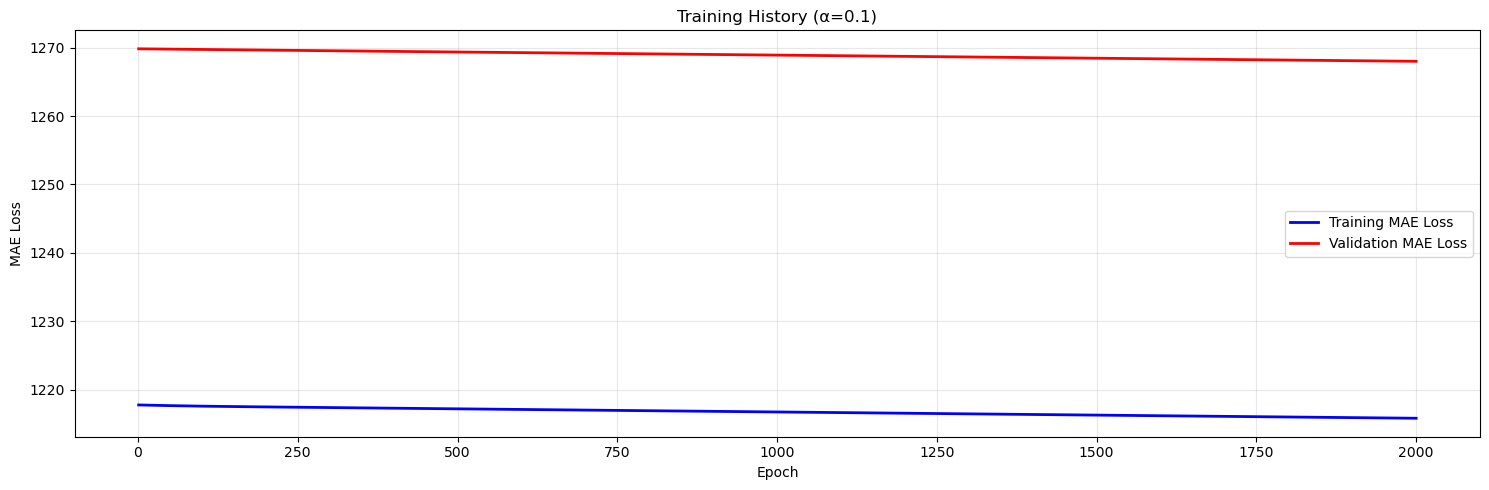


Final MAE Linear Regression Model Evaluation on Test Set:
MAE: 1288.54 days
RMSE: 1798.93 days
R² Score: -1.0535


In [ ]:
#| echo: false
#| warning: false

# Visualize training loss over epochs: AI Assisted
plt.figure(figsize=(15, 5))

# Plot: Training and Validation Loss
epochs = range(1, len(best_model.train_losses_) + 1)
plt.plot(epochs, best_model.train_losses_, 'b-', label='Training MAE Loss', linewidth=2)
plt.plot(epochs, best_model.val_losses_, 'r-', label='Validation MAE Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title(f'Training History (α={best_alpha})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final model evaluation on test set
test_predictions = best_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal MAE Linear Regression Model Evaluation on Test Set:")
print(f"=" * 55)
print(f"MAE: {test_mae:.2f} days")
print(f"RMSE: {test_rmse:.2f} days")
print(f"R² Score: {test_r2:.4f}")

### Random Forest Regressor

Random Forest Regressor is implemented to predict patient survival time based on the preprocessed BRCA dataset. Design choices include:
- **Model Choice**: Random Forest is selected for its robustness, ability to handle high-dimensional data, and effectiveness in capturing complex interactions between features.
- **Hyperparameter Tuning**: A grid search with cross-validation employed to optimize key hyperparameters such as the number of estimators, maximum depth of the trees, and minimum samples per leaf.
- **Evaluation Metrics**: Model performance evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) to provide a comprehensive assessment of prediction accuracy.

In [ ]:
#| echo: false
#| warning: false

# Random Forest Regressor: AI Assisted for documentation and refactoring

# Random Forest handles mixed data types well, so we can use the original data directly
# Resplit the original brca_df for Random Forest
X_rf = brca_df.drop('survival_time_days', axis=1)
y_rf = brca_df['survival_time_days']

# Split into training and testing sets for Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Convert categorical columns to numeric codes for Random Forest compatibility
categorical_cols = [col for col in X_train_rf.columns if X_train_rf[col].dtype == 'category']
for col in categorical_cols:
    X_train_rf[col] = X_train_rf[col].cat.codes
    X_test_rf[col] = X_test_rf[col].cat.codes

print("Training Random Forest Regressor with Hyperparameter Tuning...")
print("=" * 65)

# Define hyperparameter search space for Random Forest
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False],
    'random_state': [42]
}

# Initialize Random Forest regressor
rf_regressor = RandomForestRegressor(
    random_state=42,
    n_jobs=-1, 
    warm_start=False,
    oob_score=True  
)

# Randomized search for hyperparameter tuning
print("Performing hyperparameter tuning with 5-fold cross-validation...")
random_search_rf = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # MAE as primary metric
    n_jobs=-1,  
    random_state=42,
    verbose=1
)

# Fit the randomized search
random_search_rf.fit(X_train_rf, y_train_rf)

# Get the best model
best_rf_model = random_search_rf.best_estimator_

print(f"\nBest Random Forest Parameters:")
for param, value in random_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation MAE: {-random_search_rf.best_score_:.2f}")

# Train the model and track out-of-bag score
if best_rf_model.bootstrap:
    print(f"Out-of-Bag Score (R²): {best_rf_model.oob_score_:.4f}")

Training Random Forest Regressor with Hyperparameter Tuning...
Performing hyperparameter tuning with 5-fold cross-validation...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Random Forest Parameters:
  random_state: 42
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: 0.3
  max_depth: None
  bootstrap: True

Best Cross-Validation MAE: 755.05
Out-of-Bag Score (R²): 0.1786

Best Random Forest Parameters:
  random_state: 42
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: 0.3
  max_depth: None
  bootstrap: True

Best Cross-Validation MAE: 755.05
Out-of-Bag Score (R²): 0.1786


Evaluating Random Forest Model on Test Set...
Random Forest Model Evaluation on Test Set:
MAE: 792.40 days
RMSE: 1156.06 days
R² Score: 0.1519

Feature Importance Statistics:
Number of features with importance > 0.01: 25
Cumulative importance of top 10 features: 0.6256


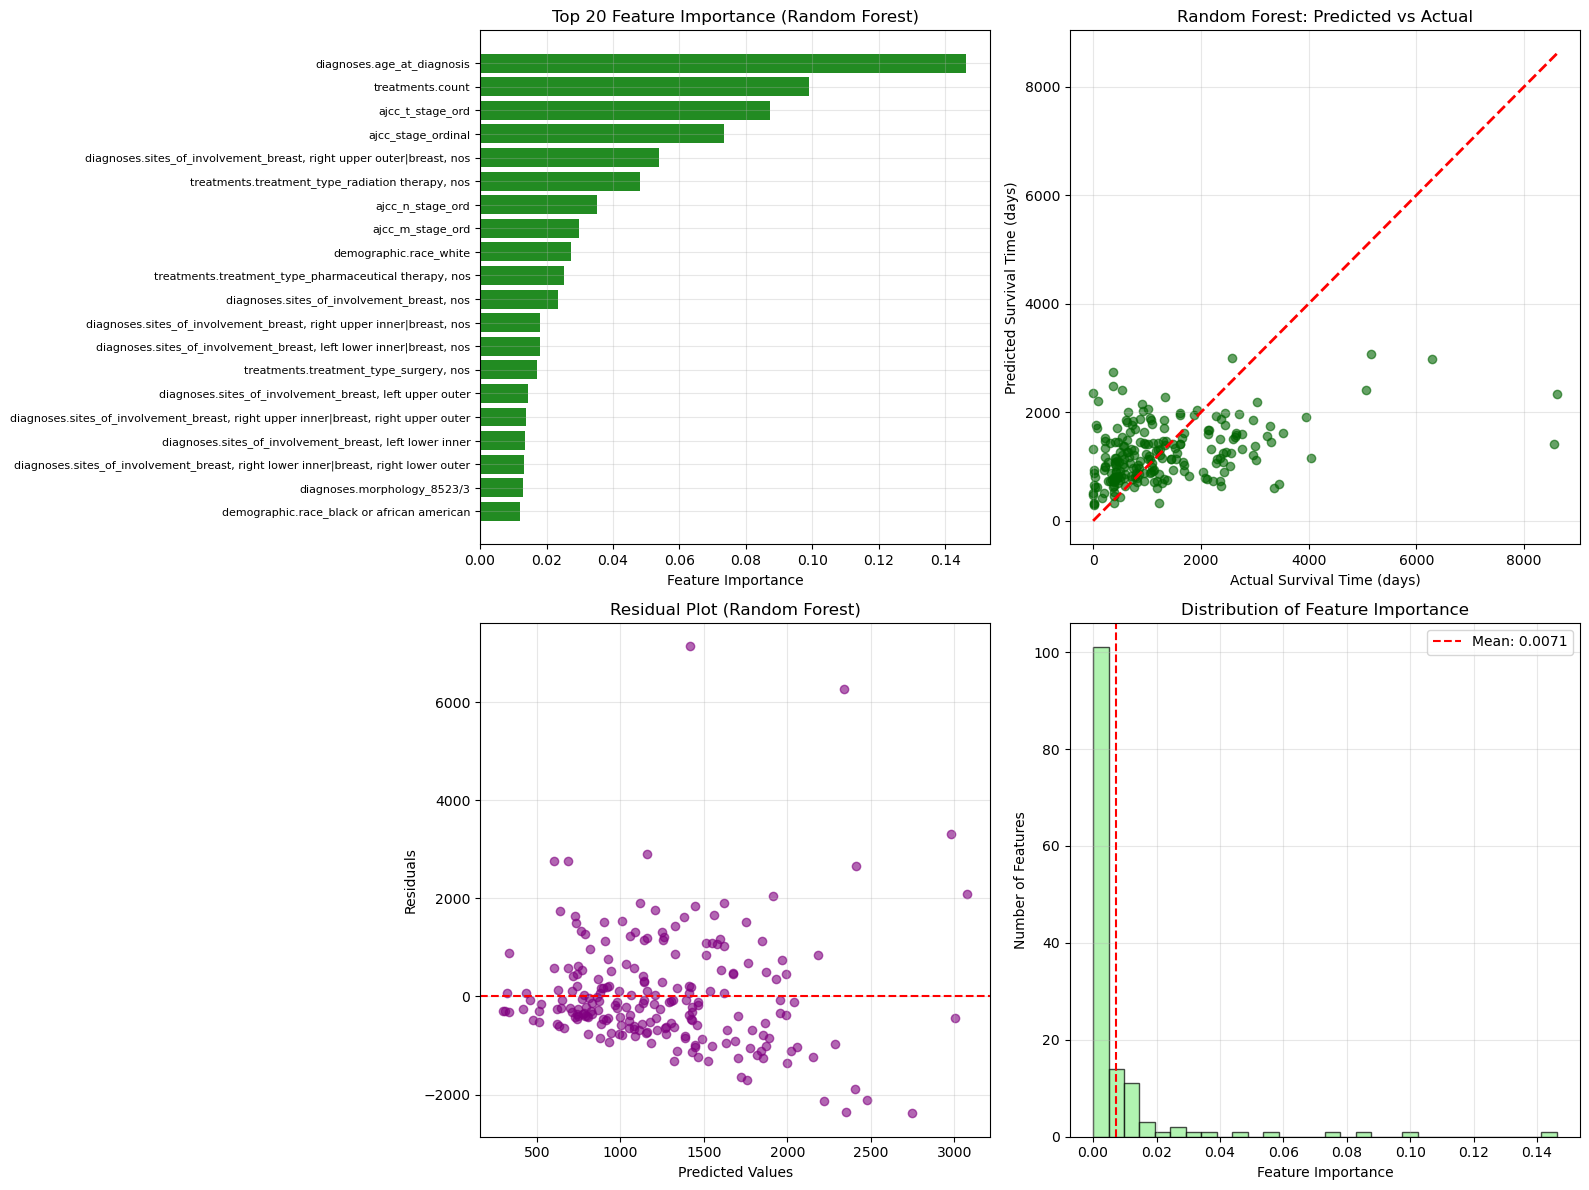


Random Forest Model Complexity:
Number of trees: 300
Max depth: None
Total number of nodes: 147756
Average tree depth: 29.93


In [ ]:
#| echo: false
#| warning: false

# Evaluate Random Forest model on test set
print("Evaluating Random Forest Model on Test Set...")
print("=" * 50)

# Make predictions
rf_predictions = best_rf_model.predict(X_test_rf)

# Calculate evaluation metrics
rf_mae = mean_absolute_error(y_test_rf, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_predictions))
rf_r2 = r2_score(y_test_rf, rf_predictions)

print(f"Random Forest Model Evaluation on Test Set:")
print(f"MAE: {rf_mae:.2f} days")
print(f"RMSE: {rf_rmse:.2f} days")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance analysis
feature_importance = best_rf_model.feature_importances_
feature_names = X_train_rf.columns

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[-20:]
top_features = feature_names[top_indices]
top_importance = feature_importance[top_indices]

# Calculate feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Number of features with importance > 0.01: {np.sum(feature_importance > 0.01)}")
print(f"Cumulative importance of top 10 features: {np.sum(feature_importance[np.argsort(feature_importance)[-10:]]):.4f}")

# Comprehensive visualization of Random Forest results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Feature Importance (Top 20)
axes[0, 0].barh(range(len(top_features)), top_importance, color='forestgreen')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features, fontsize=8)
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title('Top 20 Feature Importance (Random Forest)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual
axes[0, 1].scatter(y_test_rf, rf_predictions, alpha=0.6, color='darkgreen')
axes[0, 1].plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Survival Time (days)')
axes[0, 1].set_ylabel('Predicted Survival Time (days)')
axes[0, 1].set_title('Random Forest: Predicted vs Actual')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals Analysis
residuals = y_test_rf - rf_predictions
axes[1, 0].scatter(rf_predictions, residuals, alpha=0.6, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot (Random Forest)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importance Distribution
axes[1, 1].hist(feature_importance, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('Distribution of Feature Importance')
axes[1, 1].axvline(x=np.mean(feature_importance), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(feature_importance):.4f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model complexity analysis
print(f"\nRandom Forest Model Complexity:")
print(f"Number of trees: {best_rf_model.n_estimators}")
print(f"Max depth: {best_rf_model.max_depth}")
print(f"Total number of nodes: {sum(tree.tree_.node_count for tree in best_rf_model.estimators_)}")
print(f"Average tree depth: {np.mean([tree.tree_.max_depth for tree in best_rf_model.estimators_]):.2f}")

## Final Model Comparison and Analysis

In [ ]:
#| echo: false
#| warning: false

# Final Model Comparison: AI Assisted for presentation and clarity
print("=" * 70)
print("                    FINAL MODEL COMPARISON")
print("=" * 70)

# Create comparison dataframe with all three models
comparison_data = {
    'Model': ['Standard Linear Regression', 'Parametric Curve Fitting', 'Random Forest Regressor'],
    'MAE': [mae, test_mae, rf_mae],
    'RMSE': [rmse, test_rmse, rf_rmse],
    'R²': [r2, test_r2, rf_r2]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['MAE'] = comparison_df['MAE'].round(2)
comparison_df['RMSE'] = comparison_df['RMSE'].round(2)
comparison_df['R²'] = comparison_df['R²'].round(4)

# Find best model (lowest MAE)
best_mae_idx = comparison_df['MAE'].idxmin()

# Display table with highlighting
print("\n" + comparison_df.to_string(index=False))

print(f"\n" + "=" * 70)
print(f"BEST MODEL: {comparison_df.iloc[best_mae_idx]['Model']}")
print(f"   Achieved lowest MAE of {comparison_df.iloc[best_mae_idx]['MAE']} days")
print("=" * 70)

                    FINAL MODEL COMPARISON

                     Model          MAE         RMSE            R²
Standard Linear Regression 7.691527e+12 6.158508e+13 -2.406669e+21
  Parametric Curve Fitting 1.288540e+03 1.798930e+03 -1.053500e+00
   Random Forest Regressor 7.924000e+02 1.156060e+03  1.519000e-01

BEST MODEL: Random Forest Regressor
   Achieved lowest MAE of 792.4 days


# Cervical (CESC) Cancer Survival Time (days) Prediction Using Supervised Learning Models

## Data Preprocessing

Similar to the brca data, we had preserved multiple rows from the same patient in the cesc data to track treatments recevied during exploratory data analysis.

In [ ]:
#| echo: false
#| warning: false
#| tbl-cap: "First two rows of the eda CESC clinical dataset."

# Load the data
cesc_df = pd.read_csv('data/processed-data/cesc/cesc-clinical-processed.tsv', sep='\t')
cesc_df.head(2)

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.figo_stage,diagnoses.figo_staging_edition_year,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,diagnoses.tumor_grade,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior,exposures.tobacco_smoking_status
0,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment3,yes,"hysterectomy, nos",2234.0,malignant,current smoker
1,tcga-cesc,00bca18c-b3d4-45a3-8f19-034cc40449a4,squamous cell neoplasms,diagnosis,yes,cervix uteri,tcga-c5-a2lv,NaN,not hispanic or latino,female,black or african american,tcga-c5-a2lv_demographic,alive,36.0,mx,n1,t1b,primary,0,2234.0,stage ib,1995,biopsy,8070/3,"squamous cell carcinoma, nos",False,False,cervix uteri,tcga-c5-a2lv_diagnosis,False,cervix uteri,g3,tcga-c5-a2lv_treatment2,no,"radiation therapy, nos",2234.0,malignant,current smoker


However, for supervised learning, this could lead to data leakage during model training and evaluation. To mitigate this, we implemented a preprocessing step to retain only one record per patient. We selected the most recent record for each patient based on the 'days_to_last_followup' attribute, and created a column `treatment.count` to captuure the effect of multiple treatments a patient received.

In [ ]:
#| echo: false
#| warning: false

# Remove duplicate cases.submitter_id columns by first grouping by the column, taking a count of each group as treatments.count, then preserving row with treatments.treatment_or_therapy = true else preserve the first row in each group

# Add a count column for each group of cases.submitter_id
cesc_df['treatments.count'] = cesc_df.groupby('cases.submitter_id')['cases.submitter_id'].transform('count')

# Create a custom sorting key to prioritize rows with treatments.treatment_or_therapy = True
def create_sort_key(df):
    """Create a sort key that prioritizes treatment_or_therapy = True, then original index"""
    # Convert to string
    treatment_col = df['treatments.treatment_or_therapy'].astype(str).str.lower()
    
    # Create priority: True gets 0 (highest priority), others get 1
    priority = (treatment_col != 'true').astype(int)
    
    return priority

# Sort by cases.submitter_id and then by custom priority
cesc_df['sort_priority'] = create_sort_key(cesc_df)
cesc_df_sorted = cesc_df.sort_values(['cases.submitter_id', 'sort_priority'])

# Keep the first row for each cases.submitter_id
cesc_df_deduplicated = cesc_df_sorted.drop_duplicates(subset=['cases.submitter_id'], keep='first')

# Remove the temporary sorting column
cesc_df_deduplicated = cesc_df_deduplicated.drop('sort_priority', axis=1)

print(f"\nAfter deduplication:")
print(f"Deduplicated dataset shape: {cesc_df_deduplicated.shape}")
print(f"Unique cases.submitter_id: {cesc_df_deduplicated['cases.submitter_id'].nunique()}")
print(f"Rows removed: {cesc_df.shape[0] - cesc_df_deduplicated.shape[0]}")

# Show treatment distribution in deduplicated data
print(f"\nTreatment distribution in deduplicated data:")
print(cesc_df_deduplicated['treatments.treatment_or_therapy'].value_counts(dropna=False))

# Update the main dataframe
cesc_df = cesc_df_deduplicated.copy()
print(f"\nFinal CESC dataset shape: {cesc_df.shape}")


After deduplication:
Deduplicated dataset shape: (184, 39)
Unique cases.submitter_id: 184
Rows removed: 688

Treatment distribution in deduplicated data:
treatments.treatment_or_therapy
yes        118
no          49
unknown     17
Name: count, dtype: int64

Final CESC dataset shape: (184, 39)


In [ ]:
#| echo: false
#| warning: false

# Save the cleaned dataset
cesc_df.to_csv('data/processed-data/cesc/cesc-clinical-ml.tsv', sep='\t', index=False)

Our next step involved feature selection to enhance model performance and interpretability. We focused on removing non-informative features that exhibited low variance across the dataset. Features with little to no variability do not contribute meaningful information for predicting survival time and can introduce noise into the model.

**Remove Non-informative Features**: Exclude features with low variance e.g., behavior of the tumor is malignant for all samples. Dropped features:
   - `project_id`: represents the project and is constant for all samples.
   - `case_id`: unique identifier for each case, not useful for prediction.
   - `submitter_id`: unique identifier for each submitter, not useful for prediction.
   - `primary_site`: all samples are from the breast, so this feature has no variance.
   - `index_date`: date of indexing, not relevant for prediction.
   - `lost_to_followup`: not applicable for prediction, a tracker for patients when patient stopped participating in follow-up before the study recorded their death
   - `days_to_death`: not applicable for all samples, leading to missing values.
   - `ethnicity`: heavy imbalance to not hispanic or latino (over 80% of samples), leading to low variance. Race might capture the variance better.
   - `gender`: all samples are female, so this feature has no variance
   - `classification_of_tumor`: all samples are primary, so this feature has no variance.
   - `days_to_diagnosis`: 0 for all samples, so this feature has no variance.
   - `diagnoses.figo_staging_edition_year`: Used to determine stage, stage will be used instead.
   - `days_to _last_follow_up`: not applicable for all samples, leading to missing values.
   - `diagnoses.prior_treatment`: heavy imbalance to false , leading to low variance. Assuming number of treatments is more informative.
   - `vital_status`: does not make sense to predict survival time based on whether the patient is alive or dead at last follow-up.
   - `diagnoses.tissue_or_organ_of_origin`: all samples are from the cervix, so this feature has no variance.
   - `site_of_resection_or_biopsy`: all samples are from the cervix, so this feature has no variance. Specific location within the breast (sites_of_involvement) may provide more detailed information.
   - `synchronous_malignancy`: heavy imbalance to false (> 97%), so this feature has no variance.
   - `treatments.submitter_id`: unique identifier for each submitter, not useful for prediction.
   - `treatments_or_therapy`: Heavy imbalance to true as most patients receive treatment, so this feature has low variance. Specific treatment types may provide more information.
   - `diagnoses.diagnosis_is_primary_disease`: all samples are primary, so this feature has no variance.
   - `diagnoses.method_of_diagnosis`: Not informative to how long a patient survives. The primary diagnosis might be more relevant.


In [ ]:
#| echo: false
#| warning: false

# Remove non-informative columns above
non_informative_cols = [
    'project.project_id',              
    'cases.case_id',                   
    'cases.submitter_id',              
    'cases.primary_site',              
    'cases.index_date',
    'cases.lost_to_followup', 
    'cases.primary_site',           
    'demographic.days_to_death',       
    'demographic.gender',              
    'demographic.submitter_id',        
    'diagnoses.classification_of_tumor', 
    'diagnoses.days_to_diagnosis',     
    'diagnoses.days_to_last_follow_up',           
    'diagnoses.prior_treatment',       
    'diagnoses.site_of_resection_or_biopsy', 
    'demographic.vital_status',
    'diagnoses.synchronous_malignancy', 
    'diagnoses.submitter_id',          
    'treatments.submitter_id',      
    'demographic.submitter_id',
    'diagnoses.figo_staging_edition_year',   
    'treatments.treatment_or_therapy', 
    'diagnoses.behavior',
    'demographic.ethnicity',
    'diagnoses.method_of_diagnosis',
    'diagnoses.tissue_or_organ_of_origin'            
]

# Drop the non-informative columns
cesc_df_clean = cesc_df.drop(columns=non_informative_cols)

print(f"Original dataset shape: {cesc_df.shape}")
print(f"Cleaned dataset shape: {cesc_df_clean.shape}")
print(f"Columns removed: {cesc_df.shape[1] - cesc_df_clean.shape[1]}")

# Update the main dataframe
cesc_df = cesc_df_clean.copy()

Original dataset shape: (184, 39)
Cleaned dataset shape: (184, 15)
Columns removed: 24


Lastly, we prepared the data for modeling by applying appropriate transformations to different types of variables:

1. **Normalization**: Numerical columns `age_at_diagnosis` and `treatments.count` normalized using Min-Max scaling.
2. **Boolean Variables**: Converted boolean variables to integers (0 and 1) for model compatibility, vital status to 1 for alive
3. **Ordinal Categorical Variables**: Used Ordinal Encoding for features with an inherent order (e.g., ``tumor_stage`).
4.  **Encoding Categorical Variables**: Categorical variables were encoded using One-Hot Encoding to convert them into a format suitable for machine learning algorithms.

In [ ]:
#| echo: false
#| warning: false

# Min - Max scale diagnoses.age_at_diagnosis
scaler = MinMaxScaler()
cesc_df['diagnoses.age_at_diagnosis'] = scaler.fit_transform(cesc_df[['diagnoses.age_at_diagnosis']])
cesc_df['treatments.count'] = scaler.fit_transform(cesc_df[['treatments.count']])

In [ ]:
#| echo: false
#| warning: false

# Change the following 'diagnoses.prior_malignancy' to integers (0 and 1)
cesc_df['diagnoses.prior_malignancy'] = cesc_df['diagnoses.prior_malignancy'].map({True: 1, False: 0})

In [ ]:
#| echo: false
#| warning: false

# Map pathologic_t to ordinal values
t_stage_map = {
    'tis': 0,  # carcinoma in situ
    't1a1': 1, 't1a2': 2, 't1b1': 3, 't1b2': 4, 't1b': 5, 't1c': 6,
    't2a1': 7, 't2a2': 8, 't2a': 9, 't2b': 10, 't2': 11,
    't3a': 12, 't3b': 13, 't3': 14,
    't4': 15,
    'tx': -1  # cannot be assessed
}

cesc_df['ajcc_t_stage_ord'] = (
    cesc_df['diagnoses.ajcc_pathologic_t']
    .str.lower()                      
    .map(t_stage_map)
)

In [ ]:
#| echo: false
#| warning: false

# Similar mapping for patholigic_n
n_mapping = {
    'n0': 0, 'n0 (i-)': 0,
    'n0 (i+)': 0.5, 'n0 (mol+)': 0.5,
    'n1': 1, 'n1a': 1, 'n1b': 1, 'n1c': 1, 'n1mi': 1,
    'n2': 2, 'n2a': 2, 'n2b': 2,
    'n3': 3, 'n3a': 3, 'n3b': 3, 'n3c': 3,
    'nx': -1
}

cesc_df['ajcc_n_stage_ord'] = cesc_df['diagnoses.ajcc_pathologic_n'].str.lower().map(n_mapping) 

In [ ]:
#| echo: false
#| warning: false

# Similar mapping for patholigic_m
m_mapping = {
    'm0': 0,
    'cm0 (i+)': 0.5,
    'm1': 1,
    'mx': -1
}

cesc_df['ajcc_m_stage_ord'] = (
    cesc_df['diagnoses.ajcc_pathologic_m']
    .str.lower()
    .map(m_mapping)
)

In [ ]:
#| echo: false
#| warning: false

# Change the columns to ordered categorical types
ordinal_cols = [
    'ajcc_t_stage_ord',
    'ajcc_n_stage_ord',
    'ajcc_m_stage_ord'
]
for col in ordinal_cols:
    cesc_df[col] = pd.Categorical(
        cesc_df[col],
        ordered=True
    )

In [ ]:
#| echo: false
#| warning: false

# Drop original AJCC columns after creating ordinal versions
ajcc_original_cols = [
    'diagnoses.ajcc_pathologic_t',
    'diagnoses.ajcc_pathologic_n',
    'diagnoses.ajcc_pathologic_m']

cesc_df = cesc_df.drop(columns=ajcc_original_cols)

In [ ]:
#| echo: false
#| warning: false

# Map tumor_grade to ordinal values

# Tumor grade ordinal mapping
tumor_grade_mapping = {
    "g1": 1,   
    "g2": 2,   
    "g3": 3,   
    "g4": 4,  
    "gx": -1 
}

# Apply mapping
cesc_df["tumor_grade_ordinal"] = cesc_df["diagnoses.tumor_grade"].str.lower().map(tumor_grade_mapping)

# Drop original tumor_grade column
cesc_df = cesc_df.drop(columns=["diagnoses.tumor_grade"])


In [ ]:
#| echo: false
#| warning: false

# View unique value counts for pathologic_n column
print(f"\nUnique value counts for diagnoses.ajcc_pathologic_t column:")
print(cesc_df['diagnoses.figo_stage'].value_counts(dropna=False))


Unique value counts for diagnoses.ajcc_pathologic_t column:
diagnoses.figo_stage
stage ib1     64
stage ib2     24
stage iib     23
stage iiib    18
stage ib      16
stage iia2     7
stage iia      6
stage iia1     5
stage ivb      5
stage ii       4
stage i        4
stage iiia     3
stage iva      2
stage ia2      1
stage iii      1
stage ia1      1
Name: count, dtype: int64


In [ ]:
#| echo: false
#| warning: false

# Map FIGO stages to ordinal values
figo_ordinal_mapping = {
    "stage i": 0,
    "stage ia1": 1,
    "stage ia2": 2,
    "stage ib": 3,
    "stage ib1": 4,
    "stage ib2": 5,
    "stage ii": 6,
    "stage iia": 7,
    "stage iia1": 8,
    "stage iia2": 9,
    "stage iib": 10,
    "stage iii": 11,
    "stage iiia": 12,
    "stage iiib": 13,
    "stage iva": 14,
    "stage ivb": 15
}


# Apply mapping
cesc_df["figo_stage_ordinal"] = cesc_df["diagnoses.figo_stage"].str.lower().map(figo_ordinal_mapping)

# Drop original figo_stage column
cesc_df = cesc_df.drop(columns=['diagnoses.figo_stage'])

In [ ]:
#| echo: false
#| warning: false

# One hot encode remaining categorical variables
categorical_cols = ['cases.disease_type',
 'demographic.race',
 'diagnoses.morphology',
 'diagnoses.primary_diagnosis',
 'treatments.treatment_type',
 'exposures.tobacco_smoking_status']

cesc_df = pd.get_dummies(cesc_df, columns=categorical_cols, drop_first=True)

## Model Selection

The following models were evaluated for predicting patient survival time based on the preprocessed CESC dataset:
1. Standard Linear Regression: Benchmark model for comparison
2. Random Forest Regressor: For capturing non-linear relationships and interactions between features.
3. Parametric Curve Fitting: With Lasso regularization to prevent overfitting and eliminate potentially redundant features.

## Training and Testing

The dataset was split into training and testing sets using an 80-20 split. Cross-validation was employed during model training to ensure robustness and generalizability of the models.

In [ ]:
#| echo: false
#| warning: false

# Split features and target variable
X_cesc = cesc_df.drop('survival_time_days', axis=1)
y_cesc = cesc_df['survival_time_days']

# Split into training and testing sets (80-20 split)
X_train_cesc, X_test_cesc, y_train_cesc, y_test_cesc = train_test_split(X_cesc, y_cesc, test_size=0.2, random_state=42)

### Standard Linear Regression

In [ ]:
#| echo: false
#| warning: false

# Train a Linear Regression model 
lr_model_cesc = LinearRegression()
lr_model_cesc.fit(X_train_cesc, y_train_cesc)

# Get RMSE, MAE, R2 on test set
y_pred_cesc = lr_model_cesc.predict(X_test_cesc)
rmse_cesc = np.sqrt(mean_squared_error(y_test_cesc, y_pred_cesc))
mae_cesc = mean_absolute_error(y_test_cesc, y_pred_cesc)
r2_cesc = r2_score(y_test_cesc, y_pred_cesc)

# Print evaluation metrics
print(f"Linear Regression Model Evaluation on Test Set:")
print(f"RMSE: {rmse_cesc:.2f}")
print(f"MAE: {mae_cesc:.2f}")
print(f"R2 Score: {r2_cesc:.4f}")

Linear Regression Model Evaluation on Test Set:
RMSE: 1268.35
MAE: 960.32
R2 Score: -0.8628


### Parametric Curve Fitting

We do a parametric Curve Fitting with L1 regularization (Lasso) to predict patient survival time based on the preprocessed CESC dataset. Design choices include:
- **Model Choice**: Lasso regression is chosen for its ability to perform both variable selection and regularization, which helps enhance the prediction accuracy and interpretability of the statistical model it produces. In addition, early stopping is implemented to prevent overfitting during training.
- **Hyperparameter Tuning**: The regularization parameter (alpha) was tuned using cross-validation to find the optimal balance between bias and variance.
- **Evaluation Metrics**: Model performance evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) to provide a comprehensive assessment of prediction accuracy.
- SGDRegressor is used for optimization due to its efficiency with large datasets and ability to handle L1 regularization effectively.

In [ ]:
#| echo: false
#| warning: false

# Parametric Linear Regression with lasso regularization: AI Assisted for documentation and refactoring

# Standardize features for SGD
scaler_cesc = StandardScaler()
X_train_scaled_cesc = scaler_cesc.fit_transform(X_train_cesc)
X_test_scaled_cesc = scaler_cesc.transform(X_test_cesc)

# Custom training loop to track loss over epochs (reusing MAELinearRegression class)

# Split training set for validation (for early stopping)
X_train_fit_cesc, X_val_fit_cesc, y_train_fit_cesc, y_val_fit_cesc = train_test_split(
    X_train_scaled_cesc, y_train_cesc, test_size=0.2, random_state=42
)

# Train the custom MAE model with different alpha values to find best regularization
alphas = [0.001, 0.01, 0.1, 1.0]
best_model_cesc = None
best_alpha_cesc = None
best_val_score_cesc = float('inf')

print("Training MAE Linear Regression with Lasso Regularization...")
print("=" * 60)

for alpha in alphas:
    print(f"\nTesting alpha = {alpha}")
    model = MAELinearRegression(alpha=alpha, learning_rate=0.001, max_iter=2000)
    model.fit(X_train_fit_cesc, y_train_fit_cesc, X_val_fit_cesc, y_val_fit_cesc, early_stopping_rounds=100)
    
    # Evaluate on validation set
    val_pred = model.predict(X_val_fit_cesc)
    val_mae = mean_absolute_error(y_val_fit_cesc, val_pred)
    
    if val_mae < best_val_score_cesc:
        best_val_score_cesc = val_mae
        best_model_cesc = model
        best_alpha_cesc = alpha
        
print(f"\nBest alpha: {best_alpha_cesc}")
print(f"Best validation MAE: {best_val_score_cesc:.4f}")

Training MAE Linear Regression with Lasso Regularization...

Testing alpha = 0.001
Epoch 500: Train MAE = 1129.6072, Val MAE = 1096.8568
Epoch 500: Train MAE = 1129.6072, Val MAE = 1096.8568
Epoch 1000: Train MAE = 1129.0612, Val MAE = 1096.5397
Epoch 1000: Train MAE = 1129.0612, Val MAE = 1096.5397
Epoch 1500: Train MAE = 1128.5152, Val MAE = 1096.2226
Epoch 1500: Train MAE = 1128.5152, Val MAE = 1096.2226


Epoch 2000: Train MAE = 1127.9692, Val MAE = 1095.9054

Testing alpha = 0.01
Epoch 500: Train MAE = 1129.6240, Val MAE = 1096.8178
Epoch 500: Train MAE = 1129.6240, Val MAE = 1096.8178
Epoch 1000: Train MAE = 1129.0916, Val MAE = 1096.4694
Epoch 1000: Train MAE = 1129.0916, Val MAE = 1096.4694
Epoch 1500: Train MAE = 1128.5597, Val MAE = 1096.1201
Epoch 1500: Train MAE = 1128.5597, Val MAE = 1096.1201
Epoch 2000: Train MAE = 1128.0280, Val MAE = 1095.7708

Testing alpha = 0.1
Epoch 2000: Train MAE = 1128.0280, Val MAE = 1095.7708

Testing alpha = 0.1
Epoch 500: Train MAE = 1129.6547, Val MAE = 1096.6700
Epoch 500: Train MAE = 1129.6547, Val MAE = 1096.6700
Epoch 1000: Train MAE = 1129.1546, Val MAE = 1096.1732
Epoch 1000: Train MAE = 1129.1546, Val MAE = 1096.1732
Epoch 1500: Train MAE = 1128.6545, Val MAE = 1095.6765
Epoch 1500: Train MAE = 1128.6545, Val MAE = 1095.6765
Epoch 2000: Train MAE = 1128.1544, Val MAE = 1095.1798

Testing alpha = 1.0
Epoch 2000: Train MAE = 1128.1544, Val 

In [ ]:
#| echo: false
#| warning: false

# Final model evaluation on test set for cervical cancer
test_predictions_cesc = best_model_cesc.predict(X_test_scaled_cesc)
test_mae_cesc = mean_absolute_error(y_test_cesc, test_predictions_cesc)
test_rmse_cesc = np.sqrt(mean_squared_error(y_test_cesc, test_predictions_cesc))
test_r2_cesc = r2_score(y_test_cesc, test_predictions_cesc)

print(f"\nFinal MAE Linear Regression Model Evaluation on Test Set:")
print(f"=" * 55)
print(f"MAE: {test_mae_cesc:.2f} days")
print(f"RMSE: {test_rmse_cesc:.2f} days")
print(f"R² Score: {test_r2_cesc:.4f}")


Final MAE Linear Regression Model Evaluation on Test Set:
MAE: 887.97 days
RMSE: 1285.33 days
R² Score: -0.9130


Random Forest Regressor is implemented to predict patient survival time based on the preprocessed CESC dataset. Design choices include:
- **Model Choice**: Random Forest is selected for its robustness, ability to handle high-dimensional data, and effectiveness in capturing complex interactions between features.
- **Hyperparameter Tuning**: A randomized search with cross-validation employed to optimize key hyperparameters such as the number of estimators, maximum depth of the trees, and minimum samples per leaf.
- **Evaluation Metrics**: Model performance evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) to provide a comprehensive assessment of prediction accuracy.

### Random Forest Regressor

In [ ]:
#| echo: false
#| warning: false

# Random Forest Regressor: AI Assisted for documentation and refactoring

# Random Forest handles mixed data types well, so we can use the original data directly
# Resplit the original cesc_df for Random Forest
X_rf_cesc = cesc_df.drop('survival_time_days', axis=1)
y_rf_cesc = cesc_df['survival_time_days']

# Split into training and testing sets for Random Forest
X_train_rf_cesc, X_test_rf_cesc, y_train_rf_cesc, y_test_rf_cesc = train_test_split(X_rf_cesc, y_rf_cesc, test_size=0.2, random_state=42)

# Convert categorical columns to numeric codes for Random Forest compatibility
categorical_cols = [col for col in X_train_rf_cesc.columns if X_train_rf_cesc[col].dtype == 'category']
for col in categorical_cols:
    X_train_rf_cesc[col] = X_train_rf_cesc[col].cat.codes
    X_test_rf_cesc[col] = X_test_rf_cesc[col].cat.codes

print("Training Random Forest Regressor with Hyperparameter Tuning...")
print("=" * 65)

# Define hyperparameter search space for Random Forest
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False],
    'random_state': [42]
}

# Initialize Random Forest regressor
rf_regressor_cesc = RandomForestRegressor(
    random_state=42,
    n_jobs=-1, 
    warm_start=False,
    oob_score=True  
)

# Randomized search for hyperparameter tuning
print("Performing hyperparameter tuning with 5-fold cross-validation...")
random_search_rf_cesc = RandomizedSearchCV(
    estimator=rf_regressor_cesc,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # MAE as primary metric
    n_jobs=-1,  
    random_state=42,
    verbose=1
)

# Fit the randomized search
random_search_rf_cesc.fit(X_train_rf_cesc, y_train_rf_cesc)

# Get the best model
best_rf_model_cesc = random_search_rf_cesc.best_estimator_

print(f"\nBest Random Forest Parameters:")
for param, value in random_search_rf_cesc.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation MAE: {-random_search_rf_cesc.best_score_:.2f}")

# Train the model and track out-of-bag score
if best_rf_model_cesc.bootstrap:
    print(f"Out-of-Bag Score (R²): {best_rf_model_cesc.oob_score_:.4f}")

Training Random Forest Regressor with Hyperparameter Tuning...
Performing hyperparameter tuning with 5-fold cross-validation...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Random Forest Parameters:
  random_state: 42
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 10
  bootstrap: True

Best Cross-Validation MAE: 709.13
Out-of-Bag Score (R²): 0.0970

Best Random Forest Parameters:
  random_state: 42
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 10
  bootstrap: True

Best Cross-Validation MAE: 709.13
Out-of-Bag Score (R²): 0.0970


Evaluating Random Forest Model on Test Set...
Random Forest Model Evaluation on Test Set:
MAE: 730.73 days
RMSE: 921.17 days
R² Score: 0.0174

Feature Importance Statistics:
Number of features with importance > 0.01: 23
Cumulative importance of top 10 features: 0.6870
Random Forest Model Evaluation on Test Set:
MAE: 730.73 days
RMSE: 921.17 days
R² Score: 0.0174

Feature Importance Statistics:
Number of features with importance > 0.01: 23
Cumulative importance of top 10 features: 0.6870


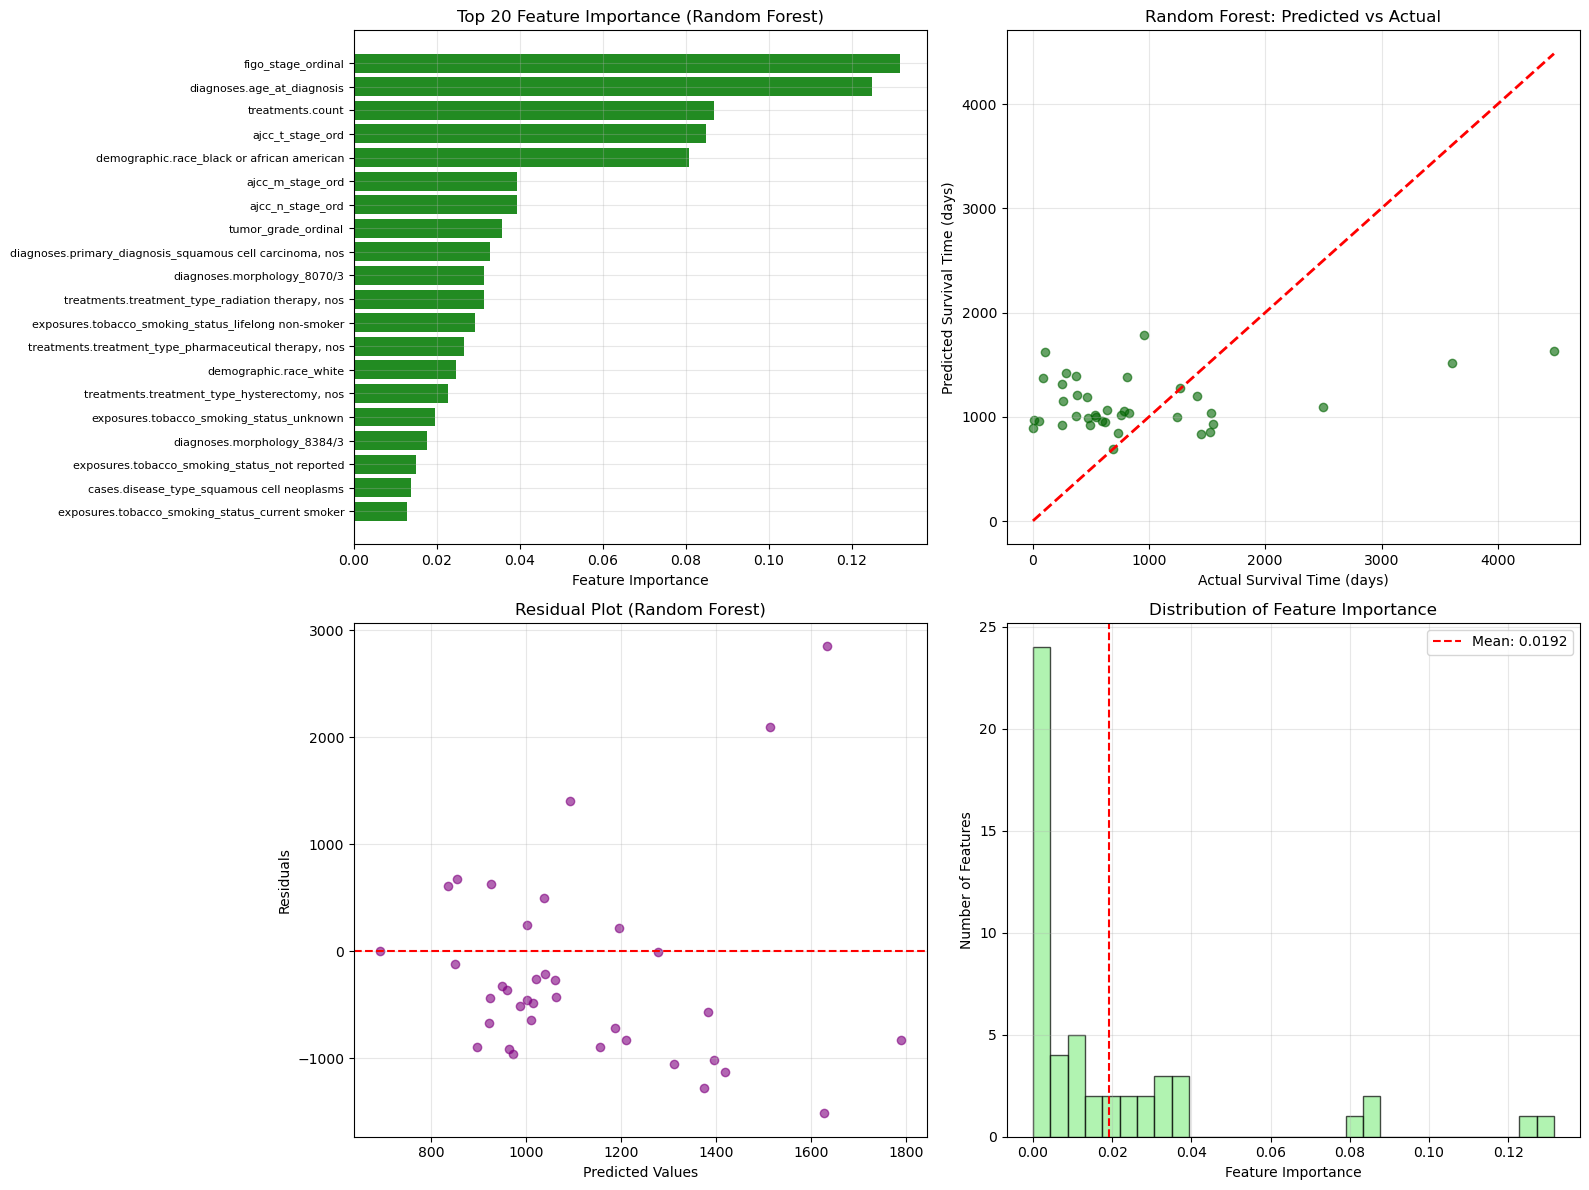


Random Forest Model Complexity:
Number of trees: 500
Max depth: 10
Total number of nodes: 24956
Average tree depth: 9.30


In [ ]:
#| echo: false
#| warning: false

# Evaluate Random Forest model on test set
print("Evaluating Random Forest Model on Test Set...")
print("=" * 50)

# Make predictions
rf_predictions_cesc = best_rf_model_cesc.predict(X_test_rf_cesc)

# Calculate evaluation metrics
rf_mae_cesc = mean_absolute_error(y_test_rf_cesc, rf_predictions_cesc)
rf_rmse_cesc = np.sqrt(mean_squared_error(y_test_rf_cesc, rf_predictions_cesc))
rf_r2_cesc = r2_score(y_test_rf_cesc, rf_predictions_cesc)

print(f"Random Forest Model Evaluation on Test Set:")
print(f"MAE: {rf_mae_cesc:.2f} days")
print(f"RMSE: {rf_rmse_cesc:.2f} days")
print(f"R² Score: {rf_r2_cesc:.4f}")

# Feature importance analysis
feature_importance_cesc = best_rf_model_cesc.feature_importances_
feature_names_cesc = X_train_rf_cesc.columns

# Get top 20 most important features
top_indices_cesc = np.argsort(feature_importance_cesc)[-20:]
top_features_cesc = feature_names_cesc[top_indices_cesc]
top_importance_cesc = feature_importance_cesc[top_indices_cesc]

# Calculate feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Number of features with importance > 0.01: {np.sum(feature_importance_cesc > 0.01)}")
print(f"Cumulative importance of top 10 features: {np.sum(feature_importance_cesc[np.argsort(feature_importance_cesc)[-10:]]):.4f}")

# Comprehensive visualization of Random Forest results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Feature Importance (Top 20)
axes[0, 0].barh(range(len(top_features_cesc)), top_importance_cesc, color='forestgreen')
axes[0, 0].set_yticks(range(len(top_features_cesc)))
axes[0, 0].set_yticklabels(top_features_cesc, fontsize=8)
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title('Top 20 Feature Importance (Random Forest)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual
axes[0, 1].scatter(y_test_rf_cesc, rf_predictions_cesc, alpha=0.6, color='darkgreen')
axes[0, 1].plot([y_test_rf_cesc.min(), y_test_rf_cesc.max()], [y_test_rf_cesc.min(), y_test_rf_cesc.max()], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Survival Time (days)')
axes[0, 1].set_ylabel('Predicted Survival Time (days)')
axes[0, 1].set_title('Random Forest: Predicted vs Actual')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals Analysis
residuals_cesc = y_test_rf_cesc - rf_predictions_cesc
axes[1, 0].scatter(rf_predictions_cesc, residuals_cesc, alpha=0.6, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot (Random Forest)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importance Distribution
axes[1, 1].hist(feature_importance_cesc, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('Distribution of Feature Importance')
axes[1, 1].axvline(x=np.mean(feature_importance_cesc), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(feature_importance_cesc):.4f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model complexity analysis
print(f"\nRandom Forest Model Complexity:")
print(f"Number of trees: {best_rf_model_cesc.n_estimators}")
print(f"Max depth: {best_rf_model_cesc.max_depth}")
print(f"Total number of nodes: {sum(tree.tree_.node_count for tree in best_rf_model_cesc.estimators_)}")
print(f"Average tree depth: {np.mean([tree.tree_.max_depth for tree in best_rf_model_cesc.estimators_]):.2f}")

In [ ]:
#| echo: false
#| warning: false

# Final Model Comparison: AI Assisted for presentation and clarity
print("=" * 70)
print("                    FINAL MODEL COMPARISON")
print("=" * 70)

# Create comparison dataframe with all three models
comparison_data_cesc = {
    'Model': ['Standard Linear Regression', 'Parametric Curve Fitting', 'Random Forest Regressor'],
    'MAE': [mae_cesc, test_mae_cesc, rf_mae_cesc],
    'RMSE': [rmse_cesc, test_rmse_cesc, rf_rmse_cesc],
    'R²': [r2_cesc, test_r2_cesc, rf_r2_cesc]
}

comparison_df_cesc = pd.DataFrame(comparison_data_cesc)
comparison_df_cesc['MAE'] = comparison_df_cesc['MAE'].round(2)
comparison_df_cesc['RMSE'] = comparison_df_cesc['RMSE'].round(2)
comparison_df_cesc['R²'] = comparison_df_cesc['R²'].round(4)

# Find best model (lowest MAE)
best_mae_idx_cesc = comparison_df_cesc['MAE'].idxmin()

# Display table with highlighting
print("\n" + comparison_df_cesc.to_string(index=False))

print(f"\n" + "=" * 70)
print(f"BEST MODEL: {comparison_df_cesc.iloc[best_mae_idx_cesc]['Model']}")
print(f"   Achieved lowest MAE of {comparison_df_cesc.iloc[best_mae_idx_cesc]['MAE']} days")
print("=" * 70)

                    FINAL MODEL COMPARISON

                     Model    MAE    RMSE      R²
Standard Linear Regression 960.32 1268.35 -0.8628
  Parametric Curve Fitting 887.97 1285.33 -0.9130
   Random Forest Regressor 730.73  921.17  0.0174

BEST MODEL: Random Forest Regressor
   Achieved lowest MAE of 730.73 days


## Final Model Comparison and Analysis

Random Forest Regressor performs best for predicting patient survival time in both BRCA and CESC datasets, demonstrating its effectiveness in handling complex relationships within clinical data. This model consistently outperforms Standard Linear Regression and Parametric Curve Fitting across all evaluation metrics (MAE, RMSE, R²). The ability of Random Forest to capture non-linear interactions and its robustness to overfitting make it a superior choice for this predictive task.

# Results and Insights

**Modeling Findings**

The survival modeling using Random Forest regressors for both breast cancer (BRCA) and cervical cancer (CESC) provides additional insight into the relative influence of demographic, clinical, and tumor-specific variables on survival time. Across both cancers, the models achieve a mean absolute error (MAE) of under 800 days, indicating that predictions deviate from the true survival time by approximately two years on average. While this may appear large in absolute terms, it is important to contextualize the MAE relative to the observed survival distributions: the BRCA cohort averages 1,324 days of survival, and the CESC cohort averages 1,036 days. Thus, an MAE of <800 days reflects moderate predictive power, consistent with the inherent difficulty of modeling survival solely with clinical variables in heterogeneous cancer populations. The implication is that the models capture broad, directional signals—such as early vs. late-stage disease—but cannot precisely predict patient-level survival due to missing biological, genomic, or treatment response data, a limitation widely noted in survival modeling literature @moore2019_survival_modeling .

**Feature Importance in Breast Cancer Survival Modeling (BRCA)**

For breast cancer, the Random Forest model identifies age at diagnosis as the most influential predictor of survival, aligning with exploratory findings and long-established evidence indicating that older patients experience reduced survival due to comorbidity burden and more aggressive tumor biology @siegel2023cancer . Treatment counts emerged as the second most important feature, suggesting that patients receiving a greater number of therapies tend to have either more aggressive disease requiring multimodal treatment or more opportunities for therapeutic benefit.

Tumor staging variables—including T stage, overall stage, N stage, and M stage—collectively comprise a substantial proportion of the model’s predictive power, underscoring the clinical reality that anatomical extent of disease remains central to prognosis. Spatial tumor descriptors, such as site of involvement (breast right upper outer), also contribute meaningfully, likely reflecting differential lymphatic drainage patterns and associated metastatic risk.

Treatment-related variables—particularly radiation therapy and pharmaceutical therapy—rank among the top predictors. Their presence in the top ten suggests that treatment modality type and intensity may partially proxy for tumor aggressiveness or patient fitness for therapy. The top ten BRCA features collectively explain over 60% of the model’s cumulative importance, demonstrating that survival in this cohort is dominated by a relatively concentrated set of clinical factors.

**Feature Importance in Cervical Cancer Survival Modeling (CESC)**

In the CESC model, FIGO stage is overwhelmingly the strongest predictor of survival, consistent with its central role in cervical cancer staging and treatment decision-making @arbyn2020cervical . Higher FIGO stages (e.g., IIB, IIIB, IVA) correlate with markedly poorer outcomes in the EDA, and this relationship is captured quantitatively by the model. Similar to BRCA, age at diagnosis and treatment counts also play major roles, though age behaves differently in CESC, reflecting the dataset-specific survival-age pattern discussed in the exploratory analysis.

Tumor burden and spread variables—T stage, N stage, and M stage—remain key predictors but are secondary to FIGO staging, which already encodes much of the disease extent. Demographic variables, particularly race (Black), enter the top ten, suggesting potential disparities in outcomes that warrant deeper investigation.

Histopathological descriptors such as tumor grade, primary diagnosis (squamous cell carcinoma), and diagnoses morphology also contribute substantially, consistent with the strong correspondence between tumor differentiation, histologic subtype, and survival in cervical cancer. The top ten CESC features account for over 68% of total model importance, indicating that survival time in this cohort is explained by an even more concentrated set of predictors than in BRCA.

**Exposure Variables and Tobacco Use**

Despite tobacco exposure being a known risk factor for developing cervical cancer, smoking-related variables did not appear in the top ten predictive features for CESC survival. This is likely due to the dataset’s distribution: as seen in the EDA, the majority of patients report being lifelong non-smokers, which diminishes the ability of the model to detect meaningful survival differences across exposure categories. Underreporting and missing exposure data may further obscure any true effect @benard2019_cervical_vitalsigns . As a result, the lack of predictive importance should not be interpreted as evidence that tobacco exposure is unrelated to cervical cancer survival, but rather as a limitation of the dataset’s completeness and variability.
